In [1]:
import sys
!{sys.executable} -m pip install --user -r requirements.txt

In [4]:
import pandas as pd
from discretization import add_labels, confusion_results
from utils import get_score
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

## Functions used

In [5]:
def find_anomaly_blocks(anomaly_labels):
    """
    Function that finds the blocks during which an attack occurred
    :param anomaly_labels: the labels of the time series 0 -> normal 1 -> attack
    :return: a list of tuples with the starting and ending indexes of each attack
    """
    anomaly_blocks = []
    prev = 0
    start = 0
    for ind, label in enumerate(anomaly_labels):
        if label == 1 and prev != 1:  # check when a new attack occurs
            start = ind
        elif label != 1 and prev == 1:  # check when an attack ends
            anomaly_blocks += [(start, ind)]
        prev = label
    return anomaly_blocks

In [6]:
def check_first_occurrence(predicted, anomaly_blocks):
    """
    Function that checks when was an attack firstly identified and returns the number of attacks
    identified and the time at which they were identified. Even if we have a positive label during an
    attack, we consider this attack as identified
    :param predicted: the predicted labels of the time series
    :param anomaly_blocks: the block of each attack
    :return: the number of attacks identified and the time at which each attack was identified
    """
    attacks = 0
    time_init = {}
    for ind, p in enumerate(predicted):
        if p == 1:
            # check if the positive label is within an actual attack block
            membership = list(map(lambda x: x[0] <= ind < x[1], anomaly_blocks))
            if True in membership:
                if membership.index(True) not in time_init.keys():  # if the attack hasn't been identified before
                    time_init[membership.index(True)] = ind  # store the time of identification
                    attacks += 1  # and increase the attack counter
    return attacks, time_init

In [7]:
def merge_predictions(predicted):
    """
    Function that merges the predictions from different sensors into one final result using the
    logical OR relationship (1 positive label is enough)
    :param predicted: the predicted labels
    :return: the merged predictions
    """
    final_predictions = np.array([0] * len(list(predicted.values())[0]))
    for pred in predicted.values():
        final_predictions = final_predictions | np.array(pred)  # merge with OR
    return final_predictions

In [8]:
def pointwise_precision_recall(predicted, true):
    """
    Function that calculates the pointwise precision and recall until each time step in the time series
    :param predicted: the predicted labels
    :param true: the true labels
    :return: the precision and recall at each time step in the series
    """
    precision = []
    recall = []
    for i in range(len(predicted)):
        TP, FP, TN, FN = confusion_results(predicted[:i+1], true[:i+1])  # the "confusion" results until the
                                                                         # current time step
        if not TP and not FP:  # if no true and false positives so far then precision = 1
            precision += [1]
        else:
            precision += [TP/(TP+FP)]

        if not TP and not FN:  # if no true positives and false negatives so far then recall = 1
            recall += [1]
        else:
            recall += [TP/(TP+FN)]
    return precision, recall

## Load the test set

In [9]:
# load the test dataset
test_df = pd.read_csv('BATADAL_datasets/BATADAL_test_dataset.csv', index_col=0, parse_dates=[0],
                      date_parser=lambda x: pd.to_datetime(x, format="%d/%m/%y %H"))
_, true_anomalies = add_labels(test_df)  # retrieve the labels of the dataset

## Load the results from the 3 methods

In [10]:
# load the results from the discrete models task
with open('discrete_all.pickle', 'rb') as handle:
    ngrams_results = pickle.load(handle)

# load the results from the pca task
with open('pca_all.pickle', 'rb') as handle:
    pca_results = pickle.load(handle)

# load the results from the ARMA task
with open('arma/arma_all.pickle', 'rb') as handle:
    arma_results = pickle.load(handle)

## Find the anomaly blocks

In [11]:
anomaly_blocks = find_anomaly_blocks(list(true_anomalies))  # find the blocks of the attacks

## The results from each sensor for ARMA

In [12]:
# start of the presentation of the results
print('------------------------ ARMA Results per sensor ------------------------')
for sensor in arma_results.keys():
    TP, FP, FN, TN, _, _, Sttd, Scm, S = get_score([i for i, val in enumerate(arma_results[sensor]) if val == 1],
                                                   [i for i, val in enumerate(list(true_anomalies)) if val == 1],
                                                   list(true_anomalies))
    attacks, _ = check_first_occurrence(arma_results[sensor], anomaly_blocks)
    print('-----------------------> %s <-----------------------' % sensor)
    print('True positive: ', TP)
    print('False positive: ', FP)
    print('True negative: ', TN)
    print('False negative: ', FN)
    print('Attacks identified: ', attacks)
    print('Sttd: ', Sttd)
    print('Scm: ', Scm)
    print('S: ', S)

------------------------ ARMA Results per sensor ------------------------
-----------------------> F_PU1 <-----------------------
True positive:  10
False positive:  0
True negative:  1682
False negative:  397
Attacks identified:  1
Sttd:  0.10599078341013823
Scm:  0.5122850122850123
S:  0.3091378978475753
-----------------------> F_PU10 <-----------------------
True positive:  0
False positive:  0
True negative:  1682
False negative:  407
Attacks identified:  0
Sttd:  0.0
Scm:  0.5
S:  0.25
-----------------------> F_PU11 <-----------------------
True positive:  0
False positive:  0
True negative:  1682
False negative:  407
Attacks identified:  0
Sttd:  0.0
Scm:  0.5
S:  0.25
-----------------------> F_PU2 <-----------------------
True positive:  0
False positive:  0
True negative:  1682
False negative:  407
Attacks identified:  0
Sttd:  0.0
Scm:  0.5
S:  0.25
-----------------------> F_PU3 <-----------------------
True positive:  60
False positive:  0
True negative:  1682
False negat

## The results from each sensor for N-grams

In [13]:
print('------------------------ N-grams Results per sensor ------------------------')
for sensor in ngrams_results.keys():
    TP, FP, FN, TN, _, _, Sttd, Scm, S = get_score([i for i, val in enumerate(ngrams_results[sensor]) if val == 1],
                                                   [i for i, val in enumerate(list(true_anomalies)) if val == 1],
                                                   list(true_anomalies))
    attacks, _ = check_first_occurrence(ngrams_results[sensor], anomaly_blocks)
    print('-----------------------> %s <-----------------------' % sensor)
    print('True positive: ', TP)
    print('False positive: ', FP)
    print('True negative: ', TN)
    print('False negative: ', FN)
    print('Attacks identified: ', attacks)
    print('Sttd: ', Sttd)
    print('Scm: ', Scm)
    print('S: ', S)

------------------------ N-grams Results per sensor ------------------------
-----------------------> L_T1 <-----------------------
True positive:  49
False positive:  53
True negative:  1629
False negative:  358
Attacks identified:  3
Sttd:  0.4127614321162708
Scm:  0.5444415066888313
S:  0.47860146940255105
-----------------------> L_T2 <-----------------------
True positive:  33
False positive:  17
True negative:  1665
False negative:  374
Attacks identified:  1
Sttd:  0.13626373626373633
Scm:  0.5354870328116463
S:  0.33587538453769133
-----------------------> L_T3 <-----------------------
True positive:  0
False positive:  0
True negative:  1682
False negative:  407
Attacks identified:  0
Sttd:  0.0
Scm:  0.5
S:  0.25
-----------------------> L_T4 <-----------------------
True positive:  0
False positive:  0
True negative:  1682
False negative:  407
Attacks identified:  0
Sttd:  0.0
Scm:  0.5
S:  0.25
-----------------------> L_T5 <-----------------------
True positive:  17
False 

## Merge the results of ARMA, N-grams and calculate the metrics for all the total results for all methods

In [14]:
arma_merged = merge_predictions(arma_results)  # merge the predictions of the sensors for ARMA
tp_arma, fp_arma, fn_arma, tn_arma, _, _, Sttd_arma, Scm_arma, S_arma = get_score(
    [i for i, val in enumerate(arma_merged) if val == 1],
    [i for i, val in enumerate(list(true_anomalies)) if val == 1],
    list(true_anomalies))

ngrams_merged = merge_predictions(ngrams_results)  # merge the predictions of the sensors for N-grams
tp_ngrams, fp_ngrams, fn_ngrams, tn_ngrams, _, _, Sttd_ngrams, Scm_ngrams, S_ngrams = get_score(
    [i for i, val in enumerate(ngrams_merged) if val == 1],
    [i for i, val in enumerate(list(true_anomalies)) if val == 1],
    list(true_anomalies))

tp_pca, fp_pca, fn_pca, tn_pca, _, _, Sttd_pca, Scm_pca, S_pca = get_score(
    [i for i, val in enumerate(pca_results) if val == 1],
    [i for i, val in enumerate(list(true_anomalies)) if val == 1],
    list(true_anomalies))

# calculate the attacks identified
attacks_arma, _ = check_first_occurrence(list(arma_merged), anomaly_blocks)
attacks_ngrams, _ = check_first_occurrence(list(ngrams_merged), anomaly_blocks)
attacks_pca, _ = check_first_occurrence(pca_results, anomaly_blocks)


## Print the metrics

In [15]:
print('------------------------ All sensors considered ------------------------')
print('True positive: ARMA -> %d N-grams -> %d PCA -> %d' % (tp_arma, tp_ngrams, tp_pca))
print('False positive: ARMA -> %d N-grams -> %d PCA -> %d' % (fp_arma, fp_ngrams, fp_pca))
print('True negative: ARMA -> %d N-grams -> %d PCA -> %d' % (tn_arma, tn_ngrams, tn_pca))
print('False negative: ARMA -> %d N-grams -> %d PCA -> %d' % (fn_arma, fn_ngrams, fn_pca))
print('Attacks detected: ARMA -> %d N-grams -> %d PCA -> %d' % (attacks_arma, attacks_ngrams, attacks_pca))
print('Sttd: ARMA -> %.3f N-grams -> %.3f PCA -> %.3f' % (Sttd_arma, Sttd_ngrams, Sttd_pca))
print('Scm: ARMA -> %.3f N-grams -> %.3f PCA -> %.3f' % (Scm_arma, Scm_ngrams, Scm_pca))
print('S: ARMA -> %.3f N-grams -> %.3f PCA -> %.3f' % (S_arma, S_ngrams, S_pca))

------------------------ All sensors considered ------------------------
True positive: ARMA -> 109 N-grams -> 307 PCA -> 257
False positive: ARMA -> 109 N-grams -> 349 PCA -> 57
True negative: ARMA -> 1573 N-grams -> 1333 PCA -> 1625
False negative: ARMA -> 298 N-grams -> 100 PCA -> 150
Attacks detected: ARMA -> 7 N-grams -> 6 PCA -> 7
Sttd: ARMA -> 0.883 N-grams -> 0.804 PCA -> 0.956
Scm: ARMA -> 0.602 N-grams -> 0.773 PCA -> 0.799
S: ARMA -> 0.742 N-grams -> 0.788 PCA -> 0.877


## Calculate and plot pointwise precision and recall

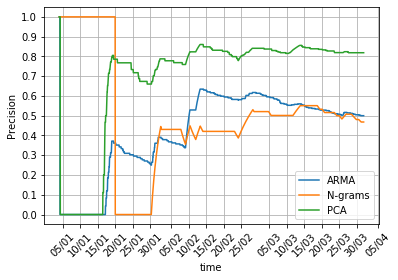

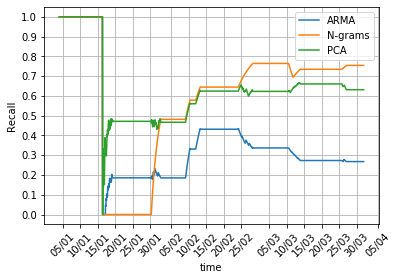

In [16]:
# calculate the pointwise precision and recall for each mehod
prec_arma, rec_arma = pointwise_precision_recall(list(arma_merged), list(true_anomalies))
prec_ngrams, rec_ngrams = pointwise_precision_recall(list(ngrams_merged), list(true_anomalies))
prec_pca, rec_pca = pointwise_precision_recall(pca_results, list(true_anomalies))

# and plot them
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pd.DataFrame(prec_arma, index=true_anomalies.index), label='ARMA')
ax.plot(pd.DataFrame(prec_ngrams, index=true_anomalies.index), label='N-grams')
ax.plot(pd.DataFrame(prec_pca, index=true_anomalies.index), label='PCA')
ax.xaxis.set_major_locator(mdates.DayLocator([5, 10, 15, 20, 25, 30]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("time")
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
# plt.savefig('plots/comparison/precision.png', bbox_inches='tight')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pd.DataFrame(rec_arma, index=true_anomalies.index), label='ARMA')
ax.plot(pd.DataFrame(rec_ngrams, index=true_anomalies.index), label='N-grams')
ax.plot(pd.DataFrame(rec_pca, index=true_anomalies.index), label='PCA')
ax.xaxis.set_major_locator(mdates.DayLocator([5, 10, 15, 20, 25, 30]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("time")
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
# plt.savefig('plots/comparison/recall.png', bbox_inches='tight')
plt.show()